# Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import bar, mole, litre, kelvin, kilojoule_per_mole, nanometer, angstrom, kilocalorie_per_mole, kilogram, molar, atmosphere, nanosecond, picosecond, femtoseconds
from openmm.unit import Quantity, Unit
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

from openmm.unit import molar, kilogram, picoseconds
from dataclasses import dataclass

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json
from pathlib import Path

import sys
sys.path.append('..')  # one level up
from salt_data import SaltData, salt_infos


/home/bamo6610/miniconda3/envs/osmotic-analysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other   

# Inputs

In [2]:
k : Quantity=4184*(kilojoule_per_mole/nanometer**2)
# k : Quantity=4184*2*(kilojoule_per_mole/nanometer**2)

L_x, L_y, L_z = 4.8, 4.8, 14.4  # lengths in x,y and z caluations
T = 300  # units: K - temperature used for calculations

z_center : Quantity=7.2 * nanometer
delta_z : Quantity=2.4 * nanometer,

NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

In [3]:
ion1="Cs"
ion2="Br"
center_atom1='Cs' 
center_atom2='Br' 
water='TIP3P'
ff_used = f'Sage 2.1 + {water}'
vantHoff=2
N_replicates=20
molalities=[4.0]

In [4]:
def load_salt_info(ion1, ion2):
    """
    Load all data entries for a specific salt from salt_info and return them as a dictionary
    where the salt appears only once with a subdictionary containing all its data.
    """
    salt = ion1 + ion2
    print(f"Salt to be analyzed: {salt}")

    # Convert dictionaries into SaltData instances
    salt_info_cleaned = [SaltData(**entry) if isinstance(entry, dict) else entry for entry in salt_infos]

    # Filter all entries that match the requested salt and store in a subdictionary
    filtered_entries = {
        f"Molality {entry.molality} mol/kg": {
            "Molarity": entry.molarity,
            "Number of Particles": math.ceil(entry.num_particles),
            "Osmotic Coefficient": entry.osmotic_coefficient,
        }
        for entry in salt_info_cleaned if entry.salt == salt
    }

    # Return results with the salt name as the top-level key
    if filtered_entries:
        return {salt: filtered_entries}
    else:
        return {"Error": f"No data found for {salt}"}


In [5]:
salt_dict=load_salt_info(ion1,ion2)
print(salt_dict)
resname_ions=(ion1+" "+ion2).upper()

wdir = Path(f'FBP_{ion1}{ion2}_{water}')
wdir.mkdir(exist_ok=True)

rdir = Path(f'{wdir}/result_files')
# rdir.mkdir(exist_ok=True)

Salt to be analyzed: CsBr
{'CsBr': {'Molality 0.1 mol/kg': {'Molarity': 0.1, 'Number of Particles': 7, 'Osmotic Coefficient': 0.917}, 'Molality 0.2 mol/kg': {'Molarity': 0.2, 'Number of Particles': 14, 'Osmotic Coefficient': 0.896}, 'Molality 0.3 mol/kg': {'Molarity': 0.3, 'Number of Particles': 20, 'Osmotic Coefficient': 0.882}, 'Molality 0.4 mol/kg': {'Molarity': 0.4, 'Number of Particles': 27, 'Osmotic Coefficient': 0.873}, 'Molality 0.5 mol/kg': {'Molarity': 0.5, 'Number of Particles': 34, 'Osmotic Coefficient': 0.865}, 'Molality 0.6 mol/kg': {'Molarity': 0.601, 'Number of Particles': 40, 'Osmotic Coefficient': 0.861}, 'Molality 0.7 mol/kg': {'Molarity': 0.701, 'Number of Particles': 47, 'Osmotic Coefficient': 0.857}, 'Molality 0.8 mol/kg': {'Molarity': 0.801, 'Number of Particles': 54, 'Osmotic Coefficient': 0.854}, 'Molality 0.9 mol/kg': {'Molarity': 0.901, 'Number of Particles': 60, 'Osmotic Coefficient': 0.852}, 'Molality 1.0 mol/kg': {'Molarity': 1.001, 'Number of Particles': 

# ANALYSIS

In [6]:
k=k.in_units_of(kilojoule_per_mole/angstrom**2) # notebook works with armstrongs, so change unit of k
Lz=L_z*10
wall1=Lz/3
wall2=wall1+wall1

@dataclass
class Wall:
    '''For representing info about the location and orientation of a wall'''
    wall_pos : Quantity
    wall_normal : Quantity

# define wall positions and ion conc parameters. This can be changed according to simulation set up.
walls = [
    Wall(
        wall_pos   =np.array([0.0, 0.0, wall1]) * angstrom,
        wall_normal=np.array([0.0, 0.0, -1.0]) * angstrom,
    ),
    Wall(
        wall_pos   =np.array([0.0, 0.0, wall2]) * angstrom,
        wall_normal=np.array([0.0, 0.0, 1.0]) * angstrom,
    ),
]

from typing import TypeAlias, TypeVar
Shape : TypeAlias = tuple
N = TypeVar('N')
M = TypeVar('M')

## Functions

In [7]:
def extract_experiment_data(data, salt):
    """
    Extracts molarity values and their corresponding osmotic coefficients
    for a given salt and stores them in two separate lists.
    
    Parameters:
        data (dict): The dictionary containing salt data.
        salt (str): The name of the salt (e.g., "NaCl").

    Returns:
        molarity_list (list): List of molarity values.
        osmotic_coeff_list (list): List of corresponding osmotic coefficients.
    """
    molarity_list = []
    osmotic_coeff_list = []

    if salt in data:
        for molality_key, values in data[f'{salt}'].items():
            molarity_list.append(values["Molarity"])
            osmotic_coeff_list.append(values["Osmotic Coefficient"])
    else:
        print(f"Salt '{salt}' not found in data.")

    return molarity_list, osmotic_coeff_list

In [8]:
def filter_coords_by_wall(
    coords_rel_wall : np.ndarray[Shape[N, M, 3], float], 
    wall_normal : np.ndarray[Shape[3], float],
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[N, M, 3], float]:
    '''Zeros out all coordinates which are not in the normal direction relative to a wall'''
    in_right_direction = np.dot(coords_rel_wall, wall_normal) > 0.0
    return np.where(in_right_direction[..., np.newaxis], coords_rel_wall, 0.0) * dist_unit # need to broadcast direction bools, since dot product reduces dimension along xyz

In [9]:
def calculate_force_matrix_all_ions_rel_wall(
    coords : np.ndarray[Shape[N, M, 3], float], 
    wall_pos : np.ndarray[Shape[3], float],
    wall_normal : np.ndarray[Shape[3], float],
    K : Quantity,
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[M], float]:
    '''Calculates net harmonic force experience by particle on one side of a wall
    coords should be a 3D array with axes of time, ion index, and spatial coordinate, respectively
    wall_pos is a vector describing the position of the wall in space
    wall_normal gives the normal direction relative to the wall (to determine whether particles behnd or ahead of the wall are kept)'''
    coords_rel_wall = coords - wall_pos
    coords_behind_wall = filter_coords_by_wall(coords_rel_wall, wall_normal=wall_normal, dist_unit=dist_unit)
    z_coords_rel_wall = coords_behind_wall[..., 2]

    # NOTE: cannot use np.abs, as this will discard unit info
    return K * abs(z_coords_rel_wall) # sum along time dimension to leave array with 1 force per particle


In [10]:
def get_universe_area_and_volume(u : mda.Universe) -> tuple[Quantity, Quantity]:
    '''Returns the XY-plane area and box volume of an MDAnalysis universe'''
    box_sizes = u.dimensions[:3] * angstrom
    box_x, box_y, box_z = box_sizes

    A_box = box_x * box_y
    V_box = A_box * box_z

    return A_box, V_box

In [11]:
def replicate_analysis(results, input_name):
    """
    Calculate the mean and uncertainty (standard error) over replicate results 
    for each molal value.
    """
    # Extract values and uncertainties from the results
    op_vals = np.array([r['os_press_mean'].value_in_unit(r['os_press_mean'].unit) for r in results])
    oc_vals = np.array([r['os_coeff_mean'] for r in results])

    # Calculate standard deviations
    std_op = op_vals.std(ddof=1)
    std_oc = oc_vals.std(ddof=1)

    # Calculate means and uncertainties (standard errors)
    mean_op = op_vals.mean()
    op_uncertainty = std_op / np.sqrt(len(op_vals))
    mean_oc = oc_vals.mean()
    oc_uncertainty = std_oc / np.sqrt(len(oc_vals))

    # Display results
    print(f"----- Results standard deviation over replicates for {input_name} molal -----")
    print(f"osmotic pressure: {mean_op:.3f} ± {op_uncertainty:.3f}")
    print(f"osmotic coefficient: {mean_oc:.3f} ± {oc_uncertainty:.3f}")

    # Prepare final results dictionary
    return {
        'mean_osmotic_pressure': mean_op,
        'uncertainty_osmotic_pressure': op_uncertainty,
        'mean_osmotic_coefficient': mean_oc,
        'uncertainty_osmotic_coefficient': oc_uncertainty,
    }

In [12]:
def load_results():
    # Get the directory of the current script
    script_dir = os.getcwd()

    # Initialize lists for OP and OC values and errors
    fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []

# Loop over molalities and replicate indices
    for mol in molalities:
        if mol % 1 == 0:
            mi1 = f"{mol:.1f}"
            mi = str(int(mol))  # Whole number: strip decimal
        else:
            mi = f"{mol:.1f}".replace('.', '')  # Float: remove the dot
            mi1 = f"{mol:.1f}"  # used in salt_dict key lookup
        # Construct the relative path to the JSON file
        relative_path = os.path.join(script_dir, wdir, f'final_results_{mi}m.json')

        # Open and load the JSON file
        with open(relative_path, 'r') as file:
            results_json = json.load(file)

        # Append values and errors to respective lists
        fbp_op_values.append(results_json['mean_osmotic_pressure'])
        fbp_op_errors.append(results_json['uncertainty_osmotic_pressure'])
        fbp_oc_values.append(results_json['mean_osmotic_coefficient'])
        fbp_oc_errors.append(results_json['uncertainty_osmotic_coefficient'])

    # Create and return the dictionary
    return {
        "OP_Values": fbp_op_values,
        "OP_Errors": fbp_op_errors,
        "OC_Values": fbp_oc_values,
        "OC_Errors": fbp_oc_errors
    }

In [13]:
def osmotic_values(
        mean_force_wall : Quantity, 
        molarity : Quantity,
        cross_sectional_area : Quantity, 
        vant_hoff : int=vantHoff,
        T : Quantity=300*kelvin, 
        printvals : bool=False
    ) -> Quantity:
    '''Compute osmotic pressure and coefficient from mean force from wall'''
    molarity = molarity.in_units_of(mole / litre)
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_coeff=osm_bar/osm_press_ideal
    
    if printvals:
        print(f"Osmotic Pressure Observed:", osm_bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        print(f"Osmotic Coefficient:", osm_coeff)

    return osm_bar, osm_coeff

In [14]:
def osm_experimental(exp_osm_coeff: float, vant_hoff: int = vantHoff, molarity: Quantity = 1*(mole/litre), T = 300*kelvin):
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    
    # Convert molarity to compatible units
    molarity = molarity.in_units_of(mole / litre)
    
    # Calculate ideal osmotic pressure
    osm_press_ideal = vant_hoff * molarity * R * T
    
    # Convert osmotic pressure to bar
    osm_press_ideal = osm_press_ideal.in_units_of(bar)
    
    # Apply experimental coefficient
    osm_bar = exp_osm_coeff * osm_press_ideal
    
    # Calculate error
    op_error = (abs(osm_bar - osm_press_ideal) / osm_press_ideal) * 100
    
    # Print values if needed
    # print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentration {molarity}')
    # print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    
    return osm_bar

In [15]:
def SPW_analysis(
        times : np.ndarray[1, Quantity],
        ion_coords : np.ndarray[Shape[N, M, 3], Quantity],
        molality_info : dict,
        A_box : Quantity,
        walls : list[Wall],
        repnum : int,
        nskip : int=100,
    ) -> None:
    '''Function that calculates osmotic pressure, osmotic coefficient, 
        and performs uncorrelated sample analysis for flat-bottom potential 
        results given as inputs'''

    SPACER = f'\n{"-"*50}\n'

    print(SPACER)
    print(f"CONCENTRATION: {molality_info}")

    #Specifying replicate number
    print("Data for replicate #",repnum)

    ## calculation of mean force matrix
    force_matrices = [
        calculate_force_matrix_all_ions_rel_wall(
            ion_coords,
            wall_pos=wall.wall_pos,
            wall_normal=wall.wall_normal,
            K=k,
            dist_unit=angstrom
        )    
        for wall in walls
     ]

    if force_matrices:
        NULL_FORCE = 0.0 * force_matrices[0].unit # needed to get sum to start with the right units (can't just add to 0)

    force_matrix = sum(force_matrices, start=NULL_FORCE) / len(force_matrices) # NOTE: need to average over all walls, and numpy can't get the job done on its own
    forces_time_avg = force_matrix.mean(axis=0)
    forces_over_all_ions = force_matrix.sum(axis=1)

    ## calculation of autocorrelation function and plot of uncorrelated samples
    # statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    t0, g, Neff_max = timeseries.detect_equilibration(forces_over_all_ions._value, nskip=nskip) # compute indices of uncorrelated timeseries
    forces_over_all_ions_equil = forces_over_all_ions[t0:]
    uncorr_sample_idxs = timeseries.subsample_correlated_data(forces_over_all_ions_equil, g=g)
    uncorr_sample_idxs = np.array(uncorr_sample_idxs)
    
    sample_forces = forces_over_all_ions_equil[uncorr_sample_idxs]
    sample_times  = times[uncorr_sample_idxs]

    # mean of full time series
    force_mean = sample_forces.mean()
    force_std  = sample_forces.std() / np.sqrt(Neff_max - 1) # TODO: make sure propagation of errors is being done correctly (since now the addition is being done up-front)

    ## calculation of osmotic values from statistical mean and std error
    print(f"RESULTS:")
    osm_press_mean, osm_coeff_mean = osmotic_values(force_mean, molarity=molality_info['Molarity'], cross_sectional_area=A_box) 
    osm_press_std , osm_coeff_std  = osmotic_values(force_std , molarity=molality_info['Molarity'], cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osm_press_mean}+/-{osm_press_std**2}")
    print(f"\nOsmotic Coefficient = {osm_coeff_mean}+/-{osm_coeff_std**2}")
    print(SPACER)
    
    ################################################################################################
    # Create dictionary with results
    results = dict()
    
    results['os_press_mean'] = osm_press_mean
    results['os_press_var'] = osm_press_std**2
    results['os_coeff_mean'] = osm_coeff_mean
    results['os_coeff_var'] = osm_coeff_std**2
    
    return results


## Load data

In [16]:
# Experimental values of osmotic coefficient obtained from Hamer & Wu paper
exp_concs, yexpOC = extract_experiment_data(salt_dict,f"{ion1}{ion2}")

# Convert quantities to scalars in appropriate units for plotting
exp_concs_values = [x*(molar) for x in exp_concs]

# Experimental values of osmotic pressure obtained from Hamer & Wu paper
yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], vant_hoff=vantHoff, molarity=exp_concs_values[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

In [17]:
import os
import numpy as np
import MDAnalysis as mda

# Initialize dictionaries
us = {}
ions = {}
ions1 = {}
ions2 = {}

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"
        mi = str(int(mol))
    else:
        mi = f"{mol:.1f}".replace('.', '')
        mi1 = f"{mol:.1f}"

    us[mi] = []
    ions[mi] = []
    ions1[mi] = []
    ions2[mi] = []

    for i in range(N_replicates):
        postfix = f'{mi}m_r{i}'
        frdir = f'{rdir}_{mi}m'
        pdb_path = os.path.join(frdir, f'md{postfix}.pdb')
        xtc_path = os.path.join(frdir, f'md{postfix}.xtc')
        cache_file = os.path.join(frdir, f'md{postfix}_ioncache.npz')

        if os.path.exists(cache_file):
            print(f'Loading cache from {cache_file}')
            data = np.load(cache_file, allow_pickle=True)
            required_keys = {'ion_indices', 'ion1_indices', 'ion2_indices', 'pdb', 'xtc'}

            if all(key in data for key in required_keys):
                u = mda.Universe(data['pdb'].item(), data['xtc'].item())
                u.transfer_to_memory()
                us[mi].append(u)

                ions[mi].append(u.atoms[data['ion_indices']])
                ions1[mi].append(u.atoms[data['ion1_indices']])
                ions2[mi].append(u.atoms[data['ion2_indices']])
                continue  # Skip to next replicate if cache was valid
            else:
                print(f"⚠️ Cache missing required keys. Rebuilding cache for {postfix}.")

        # No valid cache, process trajectory from scratch
        print(f'Processing trajectory for {postfix}')
        u = mda.Universe(pdb_path, xtc_path)
        u.transfer_to_memory()
        us[mi].append(u)

        # Select ions
        if center_atom1 != center_atom2:
            ion_group = u.select_atoms(f'element {center_atom1}', f'element {center_atom2}')
        else:
            ion_group = u.select_atoms(f'element {center_atom1}')

        ion1_group = u.select_atoms(f'resname {ion1.upper()}')
        ion2_group = u.select_atoms(f'resname {ion2.upper()}')

        ions[mi].append(ion_group)
        ions1[mi].append(ion1_group)
        ions2[mi].append(ion2_group)

        # Save updated cache
        np.savez(
            cache_file,
            pdb=pdb_path,
            xtc=xtc_path,
            ion_indices=ion_group.indices,
            ion1_indices=ion1_group.indices,
            ion2_indices=ion2_group.indices
        )
        print(f'Saved ion cache to {cache_file}')


Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r0_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r1_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r2_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r3_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r4_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r5_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r6_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r7_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r8_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r9_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r10_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r11_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r12_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_4m/md4m_r13_ioncache.npz
Lo

## Results

In [18]:
# def run_analysis(u,atom_group,saltdict,repnum):
#     '''Function to run the SPW_analysis function for every individual sample'''
#     m_info = saltdict

#     # pre-processing parameters
#     times = np.array([u.trajectory.time for _ in u.trajectory]) * picosecond
#     all_coords = u.trajectory.coordinate_array * angstrom
#     ion_coords = all_coords[:, atom_group.indices, :]

#     A_box, V_box = get_universe_area_and_volume(u)
#     wall_sep = abs(walls[1].wall_pos - walls[0].wall_pos)[2] # !NEED TO EXTRACT Z-COMPONENT OF COORDINATE DIFFERENCE!
#     V_mem = A_box * wall_sep
#     m_info['Molarity'] = m_info['Number of Particles'] / (V_mem * AVOGADRO_CONSTANT_NA)

#     # run analysis
#     results = SPW_analysis(times, ion_coords, m_info, A_box, walls, N_replicates)
#     return results

In [21]:
from openmm.unit import picosecond, angstrom, mole, litre, AVOGADRO_CONSTANT_NA

def run_analysis(u, atom_group, saltdict, repnum):
    """Run SPW_analysis using ion molarity (Quantity mol/L) instead of number density."""
    m_info = dict(saltdict)  # avoid mutating caller's dict

    # --- coordinates (with units) ---
    times = np.array([u.trajectory.time for _ in u.trajectory]) * picosecond
    all_coords = u.trajectory.coordinate_array * angstrom
    ion_coords = all_coords[:, atom_group.indices, :]

    # --- geometry/volume between walls ---
    A_box, V_box = get_universe_area_and_volume(u)     # areas/volumes with units
    wall_sep = abs((walls[1].wall_pos - walls[0].wall_pos)[2])  # length with units
    V_mem = A_box * wall_sep                           # volume with units

    # --- molarity (Quantity, mol/L) ---
    n_mol = m_info['Number of Particles'] / AVOGADRO_CONSTANT_NA    # -> Quantity [mole]
    molarity_q = (n_mol / V_mem).in_units_of(mole / litre)          # -> Quantity [mol/L]

    # Store exactly what downstream expects
    m_info['Molarity'] = molarity_q              # Quantity, used by osmotic_values(...)
    # Optional extras if you want them
    m_info['Concentration (M)'] = molarity_q.value_in_unit(mole / litre)  # float for plotting
    m_info['Quantity Type'] = 'molarity'

    # --- analysis ---
    results = SPW_analysis(times, ion_coords, m_info, A_box, walls, N_replicates)
    return results


In [22]:
# Initialize a dictionary to store results for each concentration
results = {}

# Loop over concentrations
for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05', '2.3' → '23'
        mi1 = f"{mol:.1f}"       # '0.5', '2.3'

    concentration = f"{mi}m"     # ➜ matches how you load data (e.g., '05m')
    key = f"{mi}"                # ➜ matches how you stored keys in us/ions

    results[concentration] = []

    for i, (ui, ionsi) in enumerate(zip(us[key], ions[key])):
        print(i)
        results[concentration].append(
            run_analysis(ui, ionsi, salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg'], i)
        )


0

--------------------------------------------------

CONCENTRATION: {'Molarity': 3.756407963008822 mol/L, 'Number of Particles': 267, 'Osmotic Coefficient': 0.884, 'Concentration (M)': np.float64(3.756407963008822), 'Quantity Type': 'molarity'}
Data for replicate # 20
RESULTS:
Osmotic Pressure = 235.7604695045746 bar+/-15.928198494879979 bar**2

Osmotic Coefficient = 1.2581631602789134+/-0.000453626704459626

--------------------------------------------------

1

--------------------------------------------------

CONCENTRATION: {'Molarity': 3.7617425670625395 mol/L, 'Number of Particles': 267, 'Osmotic Coefficient': 0.884, 'Concentration (M)': np.float64(3.7617425670625395), 'Quantity Type': 'molarity'}
Data for replicate # 20
RESULTS:
Osmotic Pressure = 233.3485164694601 bar+/-10.963465790903696 bar**2

Osmotic Coefficient = 1.2435255191106958+/-0.0003113487895980737

--------------------------------------------------

2

--------------------------------------------------

CONCENTR

In [23]:
def get_ion_array(u,ions):
    '''
    Function to get array of ion's z coordinate positions throughout trajectory of all samples.
    '''
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    # ionz = np.abs(np.array(ion_array) - ((L_z*10)/2))/10  # rescale the data, setting the half of the length of the box to zero
    ionz=np.array(ion_array)/10
    zvals=ionz.flatten()
    return zvals

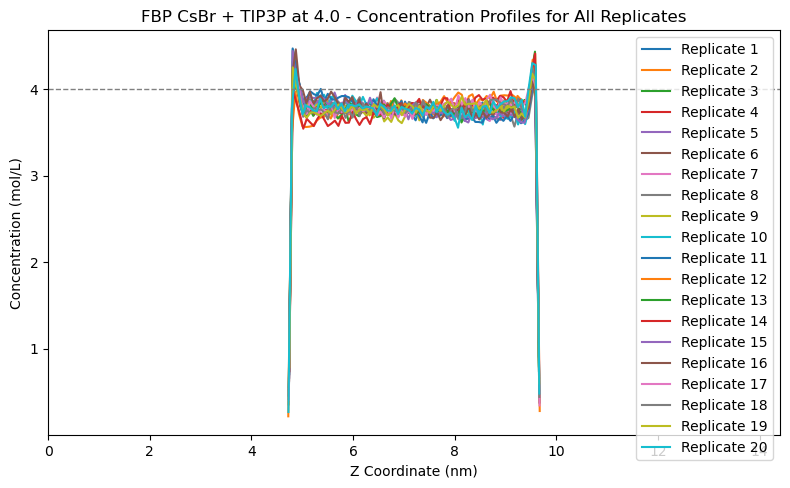

In [24]:
import matplotlib.pyplot as plt
import numpy as np

zvals = []
concentration_profiles = []
z = []

for mol in molalities:
    # Format molality
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'

    frdir = f'{rdir}_{mi}m'
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']

    plt.figure(figsize=(8, 5))  # One figure per molality

    for i in range(N_replicates):
        ui = us[mi][i]  # Universe for replicate i
        ionsi = ions[mi][i]  # Selected ions for replicate i

        zvals_i = get_ion_array(ui, ionsi)
        zvals.append(zvals_i)

        # Calculate histogram
        concs, bins = np.histogram(
            zvals_i,
            bins=int(Lz/2),
            weights=np.full_like(zvals_i, N_i / zvals_i.size)
        )
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        plt.plot(bin_centers, concs, label=f'Replicate {i+1}')  # Different color line per replicate
        concentration_profiles.append(concs)
        z.append(bin_centers)

    # Add horizontal line at bulk concentration
    plt.axhline(y=mol, color='grey', linestyle='--', linewidth=1)

    # Customize and save plot
    plt.title(f'FBP {ion1}{ion2} + {water} at {mi1} - Concentration Profiles for All Replicates')
    plt.xlabel('Z Coordinate (nm)')
    plt.ylabel('Concentration (mol/L)')
    plt.xlim(0, 14.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{wdir}/conc_prof_allreps_{mi}m_{ion1}{ion2}.png')
    plt.show()


In [25]:
# zvals = []
# concentration_profiles = []
# z = []

# for mol in molalities:
#     # Format molality
#     if mol % 1 == 0:
#         mi1 = f"{mol:.1f}"       # '1.0'
#         mi = str(int(mol))       # '1'
#     else:
#         mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
#         mi1 = f"{mol:.1f}"       # '0.5'

#     frdir = f'{rdir}_{mi}m'
#     N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']

#     replicate_profiles = []

#     for i in range(N_replicates):
#         ui = us[mi][i]
#         ionsi = ions[mi][i]

#         zvals_i = get_ion_array(ui, ionsi)
#         zvals.append(zvals_i)

#         concs, bins = np.histogram(
#             zvals_i,
#             bins=int(Lz/2),
#             weights=np.full_like(zvals_i, N_i / zvals_i.size)
#         )
#         replicate_profiles.append(concs)

#     # Compute average and SEM
#     replicate_profiles = np.array(replicate_profiles)  # shape (n_replicates, n_bins)
#     mean_profile = replicate_profiles.mean(axis=0)
#     sem_profile = replicate_profiles.std(axis=0, ddof=1) / np.sqrt(N_replicates)
#     bin_centers = 0.5 * (bins[1:] + bins[:-1])

#     # Plot
#     plt.figure(figsize=(8, 5))
#     plt.plot(bin_centers, mean_profile, color='blue', label='Mean Concentration')
#     plt.fill_between(bin_centers, mean_profile - sem_profile, mean_profile + sem_profile, 
#                      color='blue', alpha=0.3, label='SEM')

#     # Add horizontal line at bulk concentration
#     plt.axhline(y=mol, color='grey', linestyle='--', linewidth=1)

#     # Customize and save
#     plt.title(f'FBP - Mean Conc. Profile {ion1}{ion2} + {water} at {mi1}')
#     plt.xlabel('Z Coordinate (nm)')
#     plt.ylabel('Concentration (mol/L)')
#     plt.xlim(0, 14.4)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'{wdir}/conc_prof_avg_{mi}m_{ion1}{ion2}.png')
#     plt.show()

#     # Store data
#     concentration_profiles.append(mean_profile)
#     z.append(bin_centers)


In [26]:
# zvals1 = []

# for mol in molalities:
#     # Format molality
#     if mol % 1 == 0:
#         mi1 = f"{mol:.1f}"       # '1.0'
#         mi = str(int(mol))       # '1'
#     else:
#         mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
#         mi1 = f"{mol:.1f}"       # '0.5'

#     frdir = f'{rdir}_{mi}m'
#     N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']

#     replicate_profiles = []

#     for i in range(N_replicates):
#         ui = us[mi][i]
#         ions_1 = ions1[mi][i]

#         zvals_i = get_ion_array(ui, ions_1)
#         zvals1.append(zvals_i)

#         concs, bins = np.histogram(
#             zvals_i,
#             bins=int(Lz/2),
#             weights=np.full_like(zvals_i, N_i / zvals_i.size)
#         )
#         replicate_profiles.append(concs)

#     # Compute average and SEM
#     replicate_profiles = np.array(replicate_profiles)  # shape (n_replicates, n_bins)
#     mean_profile = replicate_profiles.mean(axis=0)
#     sem_profile = replicate_profiles.std(axis=0, ddof=1) / np.sqrt(N_replicates)
#     bin_centers = 0.5 * (bins[1:] + bins[:-1])

#     # Plot
#     plt.figure(figsize=(8, 5))
#     plt.plot(bin_centers, mean_profile, color='green', label='Mean Concentration')
#     plt.fill_between(bin_centers, mean_profile - sem_profile, mean_profile + sem_profile, 
#                      color='green', alpha=0.3, label='SEM')

#     # Add horizontal line at bulk concentration
#     plt.axhline(y=mol, color='grey', linestyle='--', linewidth=1)

#     # Customize and save
#     plt.title(f'FBP - Mean Conc. Profile {ion1} + {water} at {mi1}')
#     plt.xlabel('Z Coordinate (nm)')
#     plt.ylabel('Concentration (mol/L)')
#     plt.xlim(0, 14.4)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'{wdir}/conc_prof_avg_{mi}m_{ion1}.png')
#     plt.show()



In [27]:
# zvals2 = []

# for mol in molalities:
#     # Format molality
#     if mol % 1 == 0:
#         mi1 = f"{mol:.1f}"       # '1.0'
#         mi = str(int(mol))       # '1'
#     else:
#         mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
#         mi1 = f"{mol:.1f}"       # '0.5'

#     frdir = f'{rdir}_{mi}m'
#     N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']

#     replicate_profiles = []

#     for i in range(N_replicates):
#         ui = us[mi][i]
#         ions_2 = ions2[mi][i]

#         zvals_i = get_ion_array(ui, ions_2)
#         zvals2.append(zvals_i)

#         concs, bins = np.histogram(
#             zvals_i,
#             bins=int(Lz/2),
#             weights=np.full_like(zvals_i, N_i / zvals_i.size)
#         )
#         replicate_profiles.append(concs)

#     # Compute average and SEM
#     replicate_profiles = np.array(replicate_profiles)  # shape (n_replicates, n_bins)
#     mean_profile = replicate_profiles.mean(axis=0)
#     sem_profile = replicate_profiles.std(axis=0, ddof=1) / np.sqrt(N_replicates)
#     bin_centers = 0.5 * (bins[1:] + bins[:-1])

#     # Plot
#     plt.figure(figsize=(8, 5))
#     plt.plot(bin_centers, mean_profile, color='m', label='Mean Concentration')
#     plt.fill_between(bin_centers, mean_profile - sem_profile, mean_profile + sem_profile, 
#                      color='m', alpha=0.3, label='SEM')

#     # Add horizontal line at bulk concentration
#     plt.axhline(y=mol, color='grey', linestyle='--', linewidth=1)

#     # Customize and save
#     plt.title(f'FBP - Mean Conc. Profile {ion2} + {water} at {mi1}')
#     plt.xlabel('Z Coordinate (nm)')
#     plt.ylabel('Concentration (mol/L)')
#     plt.xlim(0, 14.4)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'{wdir}/conc_prof_avg_{mi}m_{ion2}.png')
#     plt.show()



In [28]:
salt_dict['CsBr']['Molality 0.1 mol/kg']['Molarity']

0.1

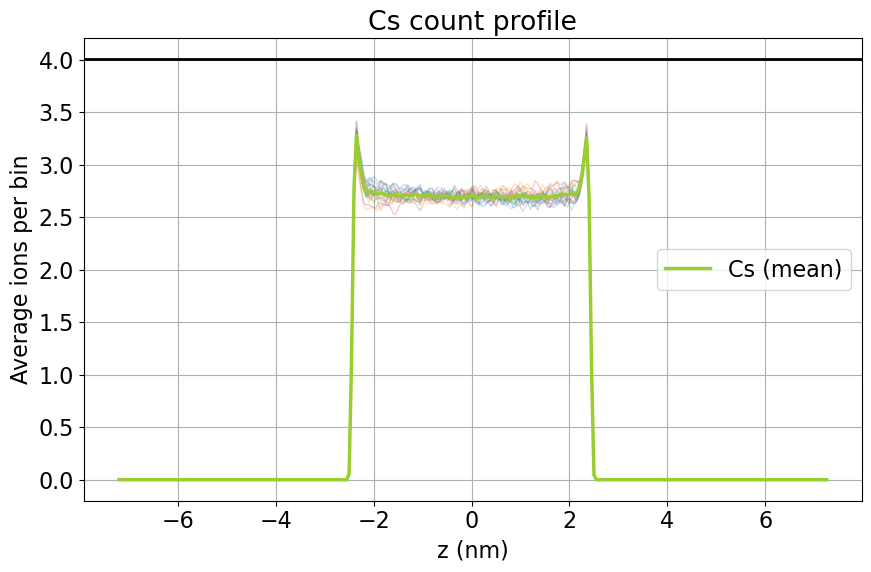

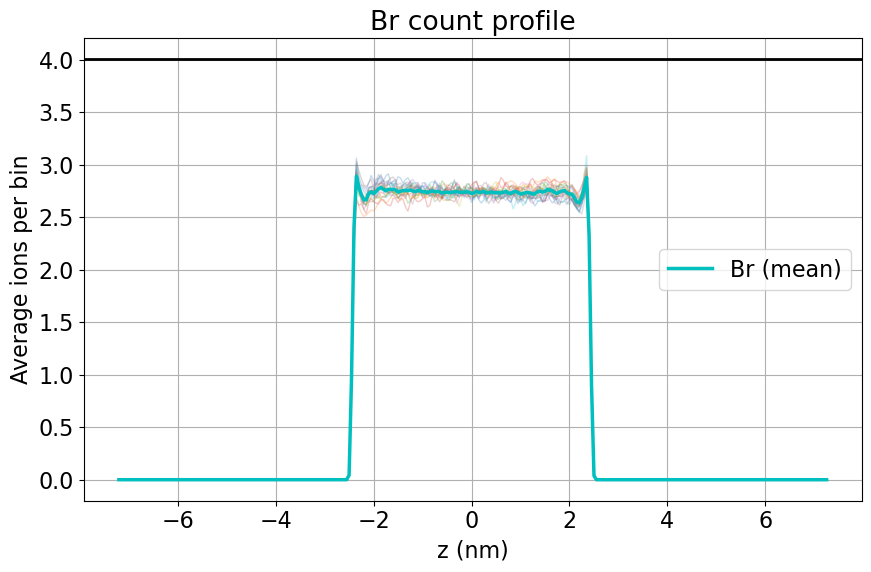

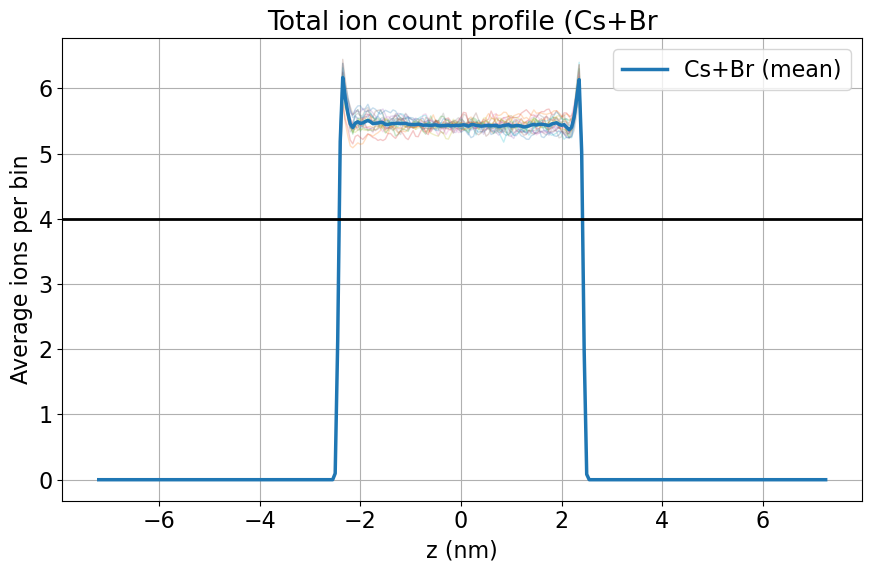

Rep 0: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 1: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 2: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 3: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 4: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 5: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 6: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 7: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 8: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 9: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 10: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 11: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 12: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 13: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 14: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 15: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 16: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 17: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 18: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 19: Cs atoms = 267

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- counts (no mol/L), unfolded ----------
def count_profile_z_fixed_Lz(u, ag, dz_nm=0.05):
    """
    Time-averaged *counts* profile along z for a fixed Lz (from first frame).
    Returns: edges (nm), centers (nm), widths (nm), avg_counts (ions/bin)
    """
    # Lz from the first frame (Å → nm)
    Lz_nm = u.trajectory.ts.dimensions[2] / 10.0
    edges = np.arange(-Lz_nm/2, Lz_nm/2 + dz_nm, dz_nm)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)

    counts_accum = np.zeros_like(centers, dtype=float)
    n_frames = len(u.trajectory)

    for ts in u.trajectory:
        mid = Lz_nm / 2.0
        z_nm = ag.positions[:, 2] / 10.0 - mid  # Å→nm and center on midplane
        counts, _ = np.histogram(z_nm, bins=edges)
        counts_accum += counts

    avg_counts = counts_accum / n_frames  # ions/bin (time-avg)
    return edges, centers, widths, avg_counts

def rebin_counts_conservative(edges_src, counts_src, edges_dst):
    """
    Rebin a piecewise-constant counts-per-bin profile onto new edges, conserving totals.
    counts_src is 'ions per bin' over intervals [edges_src[i], edges_src[i+1]).
    Output is counts_dst (ions per dst-bin).
    """
    widths_src = np.diff(edges_src)
    # Linear density (ions per nm) within each source bin
    with np.errstate(divide='ignore', invalid='ignore'):
        lam = np.zeros_like(counts_src, dtype=float)
        valid = widths_src > 0
        lam[valid] = counts_src[valid] / widths_src[valid]

    counts_dst = np.zeros(len(edges_dst)-1, dtype=float)

    i = j = 0
    while i < len(counts_src) and j < len(counts_dst):
        a, b = edges_src[i], edges_src[i+1]
        A, B = edges_dst[j], edges_dst[j+1]
        left  = max(a, A)
        right = min(b, B)
        overlap = right - left
        if overlap > 0:
            counts_dst[j] += lam[i] * overlap  # ions per nm * nm = ions
        # advance whichever interval ends first
        if b <= B:
            i += 1
        else:
            j += 1
    return counts_dst

# ===================== RUN (counts-based, unfolded, with rebin) =====================

dz_nm = 0.05  # desired global bin thickness (nm)

# Collect per-replicate raw profiles (with their own edges)
raw_ion1 = []
raw_ion2 = []
raw_tot  = []
Ns_ion1_list, Ns_ion2_list, Ns_pairs_list = [], [], []

Lz_max = 0.0

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi  = str(int(mol))      # '1'
    else:
        mi  = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']
    molar_val=salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Molarity']
    # molar_ref=molar_val.in_units_of(mole/litre)
    # molar_ref_val=molar_ref.value_in_unit(mole/litre)
    frdir = f'{rdir}_{mi}m'

    for u in us[mi]:
        ag_ion1 = u.select_atoms(f'element {center_atom1}')
        ag_ion2 = u.select_atoms(f'element {center_atom2}')

        e1, z1, w1, cts1 = count_profile_z_fixed_Lz(u, ag_ion1, dz_nm)
        e2, z2, w2, cts2 = count_profile_z_fixed_Lz(u, ag_ion2, dz_nm)

        raw_ion1.append((e1, cts1))
        raw_ion2.append((e2, cts2))
        raw_tot.append((e1, cts1 + cts2))   # same edges as e1 by construction

        Lz_max = max(Lz_max, e1[-1]-e1[0], e2[-1]-e2[0])

        # exact ion counts: topology
        Ns_ion1_list.append(ag_ion1.n_atoms)
        Ns_ion2_list.append(ag_ion2.n_atoms)
        Ns_pairs_list.append(min(ag_ion1.n_atoms, ag_ion2.n_atoms))

# ---- Build a single global grid using the maximum Lz ----
zmax = Lz_max / 2.0
edges_g = np.arange(-zmax, zmax + dz_nm, dz_nm)
centers_g = 0.5*(edges_g[:-1] + edges_g[1:])

# ---- Rebin all profiles onto the global grid ----
z_ion1_list, cnt_ion1_list = [], []
z_ion2_list, cnt_ion2_list = [], []
z_tot_list,  cnt_tot_list  = [], []

for (e1, y1), (e2, y2), (et, yt) in zip(raw_ion1, raw_ion2, raw_tot):
    y1g = rebin_counts_conservative(e1, y1, edges_g)
    y2g = rebin_counts_conservative(e2, y2, edges_g)
    ytg = rebin_counts_conservative(et, yt, edges_g)

    z_ion1_list.append(centers_g); cnt_ion1_list.append(y1g)
    z_ion2_list.append(centers_g); cnt_ion2_list.append(y2g)
    z_tot_list.append(centers_g);  cnt_tot_list.append(ytg)

# ===== replicate means (now all same length) =====
zplot_ion1 = z_ion1_list[0]
zplot_ion2 = z_ion2_list[0]
zplot_Tot  = z_tot_list[0]

ion1_stack = np.vstack(cnt_ion1_list)  # ions/bin
ion2_stack = np.vstack(cnt_ion2_list)
Tot_stack  = np.vstack(cnt_tot_list)

ion1_mean = ion1_stack.mean(axis=0)
ion2_mean = ion2_stack.mean(axis=0)
Tot_mean  = Tot_stack.mean(axis=0)

# ===================== PLOTS (ions/bin, unfolded) =====================

plt.figure(figsize=(9,6))
for y in cnt_ion1_list:
    plt.plot(zplot_ion1, y, alpha=0.25, lw=1)
plt.plot(zplot_ion1, ion1_mean, lw=2.5, label=f"{ion1} (mean)", color="yellowgreen")
plt.axhline(y=molar_val, color='k', lw=2)
plt.xlabel("z (nm)")
plt.ylabel("Average ions per bin")
plt.title(f"{ion1} count profile")
plt.grid(True); plt.legend(); plt.tight_layout()

plt.figure(figsize=(9,6))
for y in cnt_ion2_list:
    plt.plot(zplot_ion2, y, alpha=0.25, lw=1)
plt.plot(zplot_ion2, ion2_mean, lw=2.5, label=f"{ion2} (mean)", color='c')
plt.axhline(y=molar_val, color='k', lw=2)
plt.xlabel("z (nm)")
plt.ylabel("Average ions per bin")
plt.title(f"{ion2} count profile")
plt.grid(True); plt.legend(); plt.tight_layout()

plt.figure(figsize=(9,6))
for y in cnt_tot_list:
    plt.plot(zplot_Tot, y, alpha=0.25, lw=1)
plt.plot(zplot_Tot, Tot_mean, lw=2.5, label=f"{ion1}+{ion2} (mean)", color="tab:blue")
plt.axhline(y=molar_val, color='k', lw=2)
plt.xlabel("z (nm)")
plt.ylabel("Average ions per bin")
plt.title(f"Total ion count profile ({ion1}+{ion2}")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ===================== COUNTS SUMMARY =====================

for i, (Nc, Nb, Np) in enumerate(zip(Ns_ion1_list, Ns_ion2_list, Ns_pairs_list)):
    print(f"Rep {i}: {ion1} atoms = {Nc}, {ion2} atoms = {Nb}, Pairs = {Np}")

# Sanity: total ions per frame implied by the (unfolded) mean total profile
approx_total_ions = Tot_mean.sum()
print(f"Approx ions/frame from total counts (rep-mean, unfolded): ~{approx_total_ions:.2f}")


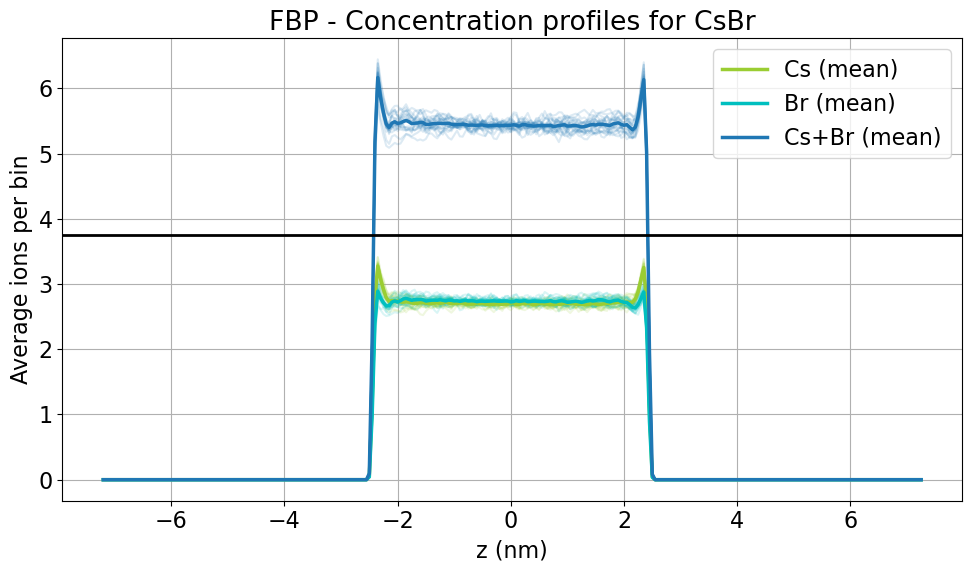

Rep 0: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 1: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 2: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 3: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 4: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 5: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 6: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 7: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 8: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 9: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 10: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 11: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 12: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 13: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 14: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 15: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 16: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 17: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 18: Cs atoms = 267, Br atoms = 267, Pairs = 267
Rep 19: Cs atoms = 267

In [ ]:
# ---------- counts (no mol/L), unfolded ----------
def count_profile_z_fixed_Lz(u, ag, dz_nm=0.05):
    """Time-averaged *counts* profile along z for a fixed Lz (from first frame)."""
    Lz_nm = u.trajectory.ts.dimensions[2] / 10.0
    edges = np.arange(-Lz_nm/2, Lz_nm/2 + dz_nm, dz_nm)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)

    counts_accum = np.zeros_like(centers, dtype=float)
    n_frames = len(u.trajectory)

    for ts in u.trajectory:
        mid = Lz_nm / 2.0
        z_nm = ag.positions[:, 2] / 10.0 - mid
        counts, _ = np.histogram(z_nm, bins=edges)
        counts_accum += counts

    avg_counts = counts_accum / n_frames
    return edges, avg_counts

def rebin_counts_conservative(edges_src, counts_src, edges_dst):
    """Rebin counts/bin profile to new edges, conserving totals."""
    widths_src = np.diff(edges_src)
    lam = np.zeros_like(counts_src, dtype=float)  # ions/nm
    valid = widths_src > 0
    lam[valid] = counts_src[valid] / widths_src[valid]

    counts_dst = np.zeros(len(edges_dst)-1, dtype=float)
    i = j = 0
    while i < len(counts_src) and j < len(counts_dst):
        a, b = edges_src[i], edges_src[i+1]
        A, B = edges_dst[j], edges_dst[j+1]
        left, right = max(a, A), min(b, B)
        overlap = right - left
        if overlap > 0:
            counts_dst[j] += lam[i] * overlap
        if b <= B:
            i += 1
        else:
            j += 1
    return counts_dst

# ===================== RUN =====================
dz_nm = 0.05
raw_ion1, raw_ion2, raw_tot = [], [], []
Ns_ion1_list, Ns_ion2_list, Ns_pairs_list = [], [], []
Lz_max = 0.0

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"; mi = str(int(mol))
    else:
        mi  = f"{mol:.1f}".replace('.', '')
        mi1 = f"{mol:.1f}"
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']
    molar_val=salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Molarity']
    molar_ref=molar_val.in_units_of(mole/litre)
    molar_ref_val=molar_ref.value_in_unit(mole/litre)
    frdir = f'{rdir}_{mi}m'

    for u in us[mi]:
        ag1 = u.select_atoms(f'element {center_atom1}')
        ag2 = u.select_atoms(f'element {center_atom2}')

        e1, cts1 = count_profile_z_fixed_Lz(u, ag1, dz_nm)
        e2, cts2 = count_profile_z_fixed_Lz(u, ag2, dz_nm)

        raw_ion1.append((e1, cts1))
        raw_ion2.append((e2, cts2))
        raw_tot.append((e1, cts1 + cts2))

        Lz_max = max(Lz_max, e1[-1]-e1[0], e2[-1]-e2[0])
        Ns_ion1_list.append(ag1.n_atoms)
        Ns_ion2_list.append(ag2.n_atoms)
        Ns_pairs_list.append(min(ag1.n_atoms, ag2.n_atoms))

# ---- global grid ----
zmax = Lz_max / 2.0
edges_g = np.arange(-zmax, zmax + dz_nm, dz_nm)
centers_g = 0.5*(edges_g[:-1] + edges_g[1:])

# ---- rebin ----
cnt_ion1_list, cnt_ion2_list, cnt_tot_list = [], [], []
for (e1, y1), (e2, y2), (et, yt) in zip(raw_ion1, raw_ion2, raw_tot):
    cnt_ion1_list.append(rebin_counts_conservative(e1, y1, edges_g))
    cnt_ion2_list.append(rebin_counts_conservative(e2, y2, edges_g))
    cnt_tot_list.append(rebin_counts_conservative(et, yt, edges_g))

ion1_stack = np.vstack(cnt_ion1_list)
ion2_stack = np.vstack(cnt_ion2_list)
tot_stack  = np.vstack(cnt_tot_list)

ion1_mean = ion1_stack.mean(axis=0)
ion2_mean = ion2_stack.mean(axis=0)
tot_mean  = tot_stack.mean(axis=0)

# ===================== SINGLE PLOT =====================
plt.figure(figsize=(10,6))

# faint replicates
for y in cnt_ion1_list:
    plt.plot(centers_g, y, alpha=0.15, color="yellowgreen")
for y in cnt_ion2_list:
    plt.plot(centers_g, y, alpha=0.15, color='c')
for y in cnt_tot_list:
    plt.plot(centers_g, y, alpha=0.15, color="tab:blue")

# bold means
plt.plot(centers_g, ion1_mean, lw=2.5, color="yellowgreen", label=f"{ion1} (mean)")
plt.plot(centers_g, ion2_mean, lw=2.5, color='c', label=f"{ion2} (mean)")
plt.plot(centers_g, tot_mean,  lw=2.5, color="tab:blue", label=f"{ion1}+{ion2} (mean)")
plt.axhline(y=molar_ref_val, color='k', lw=2)

plt.xlabel("z (nm)")
plt.ylabel("Average ions per bin")
plt.title(f"FBP - Concentration profiles for {ion1}{ion2}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===================== COUNTS SUMMARY =====================
for i, (Nc, Nb, Np) in enumerate(zip(Ns_ion1_list, Ns_ion2_list, Ns_pairs_list)):
    print(f"Rep {i}: {ion1} atoms = {Nc}, {ion2} atoms = {Nb}, Pairs = {Np}")

approx_total_ions = tot_mean.sum()
print(f"Approx ions/frame from total counts (rep-mean, unfolded): ~{approx_total_ions:.2f}")


In [30]:
import numpy as np
import matplotlib.pyplot as plt

NA = 6.02214076e23  # mol^-1

# ---------- Build time-averaged molarity profiles per replicate ----------
def conc_profile_molarity(u, ag, dz_nm=0.05):
    """
    Time-averaged molarity profile c(z) in mol/L.
    - Uses per-frame bins that exactly span that frame's Lz (no edge loss).
    - Conservatively rebins onto a global grid built from the *maximum* Lz seen in this universe.
    Returns (z_centers_global_nm, c_mean_M).
    """
    # 1) Global grid from max Lz across frames (Å -> nm)
    Lz_max_nm = max(ts.dimensions[2] for ts in u.trajectory) / 10.0
    zmax = Lz_max_nm / 2.0
    edges_g = np.arange(-zmax, zmax + dz_nm, dz_nm)
    centers_g = 0.5*(edges_g[:-1] + edges_g[1:])
    n_g = len(centers_g)

    amount_sum = np.zeros(n_g)  # accumulates (mol/L)*nm
    cover_len  = np.zeros(n_g)  # accumulates nm

    # 2) Per-frame profile -> conservative rebin to global grid
    for ts in u.trajectory:
        Lx_nm, Ly_nm, Lz_nm = ts.dimensions[:3] / 10.0
        mid = Lz_nm / 2.0

        # Per-frame edges fully covering Lz in this frame
        edges_f  = np.arange(-Lz_nm/2.0, Lz_nm/2.0 + dz_nm, dz_nm)
        widths_f = np.diff(edges_f)

        # z (Å -> nm), centered
        z_nm = ag.positions[:, 2] / 10.0 - mid
        counts, _ = np.histogram(z_nm, bins=edges_f)

        # mol/L in each frame bin
        bin_vol_L = (Lx_nm * Ly_nm) * widths_f * 1e-24  # nm^3 -> L
        with np.errstate(divide='ignore', invalid='ignore'):
            c_frame = (counts / NA) / bin_vol_L  # mol/L, piecewise-constant

        # Conservative rebin: add c * overlap to global bins
        i = j = 0
        while i < len(c_frame) and j < n_g:
            a, b = edges_f[i], edges_f[i+1]
            A, B = edges_g[j], edges_g[j+1]
            left, right = max(a, A), min(b, B)
            overlap = right - left
            if overlap > 0:
                amount_sum[j] += c_frame[i] * overlap
                cover_len[j]  += overlap
            if b <= B:
                i += 1
            else:
                j += 1

    c_mean = np.zeros_like(centers_g)
    m = cover_len > 0
    c_mean[m] = amount_sum[m] / cover_len[m]
    return centers_g, c_mean

# ---------- Rebin different replicates onto one final grid ----------
def rebin_conc_conservative(z_src, c_src, edges_dst):
    """Rebin piecewise-constant molarity profile c(z) onto edges_dst, conserving totals."""
    dz = np.median(np.diff(z_src))
    edges_src = np.concatenate(([z_src[0]-dz/2], z_src + dz/2))
    amount = np.zeros(len(edges_dst)-1)
    cover  = np.zeros(len(edges_dst)-1)
    i = j = 0
    while i < len(c_src) and j < len(amount):
        a, b = edges_src[i], edges_src[i+1]
        A, B = edges_dst[j],  edges_dst[j+1]
        left, right = max(a, A), min(b, B)
        overlap = right - left
        if overlap > 0:
            amount[j] += c_src[i] * overlap
            cover[j]  += overlap
        if b <= B:
            i += 1
        else:
            j += 1
    out = np.zeros_like(amount)
    m = cover > 0
    out[m] = amount[m] / cover[m]
    return out

# ---------- MAIN: build profiles and plot all in one figure ----------
dz_nm = 0.05

# Colors to match your figure
cs_color  = "#d6d645"   # Cs
br_color  = "#2eb5a0"   # Br
salt_color = "#206bb3"  # CsBr (mean of Cs & Br)

# Collect per-replicate profiles
z1_all, c1_all = [], []
z2_all, c2_all = [], []

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"; mi = str(int(mol))
    else:
        mi  = f"{mol:.1f}".replace('.', '')
        mi1 = f"{mol:.1f}"
    for u in us[mi]:
        ag1 = u.select_atoms(f'element {center_atom1}')
        ag2 = u.select_atoms(f'element {center_atom2}')
        z1, c1 = conc_profile_molarity(u, ag1, dz_nm)
        z2, c2 = conc_profile_molarity(u, ag2, dz_nm)
        z1_all.append(z1); c1_all.append(c1)
        z2_all.append(z2); c2_all.append(c2)
    molar_val=salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Molarity']
    molar_ref=molar_val.in_units_of(mole/litre)
    molar_ref_val=molar_ref.value_in_unit(mole/litre)
# Final common grid across *all* replicates/ions
zmax_final = max(z[-1] - z[0] for z in (z1_all + z2_all)) / 2.0
edges_g = np.arange(-zmax_final, zmax_final + dz_nm, dz_nm)
centers_g = 0.5*(edges_g[:-1] + edges_g[1:])

# Rebin everyone to final grid
c1_stack = np.vstack([rebin_conc_conservative(z, c, edges_g) for z, c in zip(z1_all, c1_all)])
c2_stack = np.vstack([rebin_conc_conservative(z, c, edges_g) for z, c in zip(z2_all, c2_all)])

# Per-salt (formula-unit) profile = mean of species profiles, not sum
salt_stack = 0.5 * (c1_stack + c2_stack)

# Replicate means
c1_mean   = c1_stack.mean(axis=0)
c2_mean   = c2_stack.mean(axis=0)
salt_mean = salt_stack.mean(axis=0)

# --------- Plot: Cs, Br, and CsBr (per-salt average) on one figure ---------
plt.figure(figsize=(10,6))

# faint replicates
for y in c1_stack:
    plt.plot(centers_g, y, alpha=0.12, color=cs_color)
for y in c2_stack:
    plt.plot(centers_g, y, alpha=0.12, color=br_color)
for y in salt_stack:
    plt.plot(centers_g, y, alpha=0.12, color=salt_color)

# bold means
plt.plot(centers_g, c1_mean,   lw=2.6, color=cs_color,   label=f"{ion1} (mean)")
plt.plot(centers_g, c2_mean,   lw=2.6, color=br_color,   label=f"{ion2} (mean)")
plt.plot(centers_g, salt_mean, lw=2.6, color=salt_color, label=f"{ion1}{ion2} (per-salt mean)")
plt.axhline(y=molar_ref_val, color='k', lw=2)

plt.xlabel("z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.title(f"FBP - Concentration profiles for {ion1}{ion2}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


AttributeError: 'float' object has no attribute 'in_units_of'

In [31]:
replicate_results = {}

for mol in molalities:
    # Format molality
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'

    keymi=f'{mi}m'
    replicate_results[f'{keymi}'] = replicate_analysis(results[keymi], mi1)


----- Results standard deviation over replicates for 4.0 molal -----
osmotic pressure: 229.323 ± 1.023
osmotic coefficient: 1.225 ± 0.005


In [32]:
replicate_results

{'4m': {'mean_osmotic_pressure': np.float64(229.32318505347786),
  'uncertainty_osmotic_pressure': np.float64(1.0227709700613672),
  'mean_osmotic_coefficient': np.float64(1.2252477030000581),
  'uncertainty_osmotic_coefficient': np.float64(0.005391058826805134)}}

In [33]:
def serialize(obj):
    if isinstance(obj, dict):
        return {k: serialize(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [serialize(item) for item in obj]
    elif isinstance(obj, Quantity):
        return {"value": round(obj.value_in_unit(obj.unit), 4), "unit": str(obj.unit)}
    elif isinstance(obj, float):
        return round(obj, 4)
    else:
        return obj

In [34]:
def format_dict(dictionary):
    '''Function that formats the decimals of the values in dictionary'''
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

In [35]:
# Loop through replicate_results and write to JSON files
for concentration, data in results.items():
    filename = f"{rdir}_{concentration}/results_{concentration}.json"
    with open(filename, "w") as outfile:
        json.dump(serialize(data), outfile, indent=4)

for concentration, data in replicate_results.items():
    filename = f"{wdir}/final_results_{concentration}.json" 
    with open(filename, "w") as outfile:
        json.dump(format_dict(data), outfile, indent=4)

# Plotting Results

In [36]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [37]:
fbp_results=load_results()

In [38]:
molalities

[4.0]

In [39]:
fbp_results['OC_Values']

[1.225]

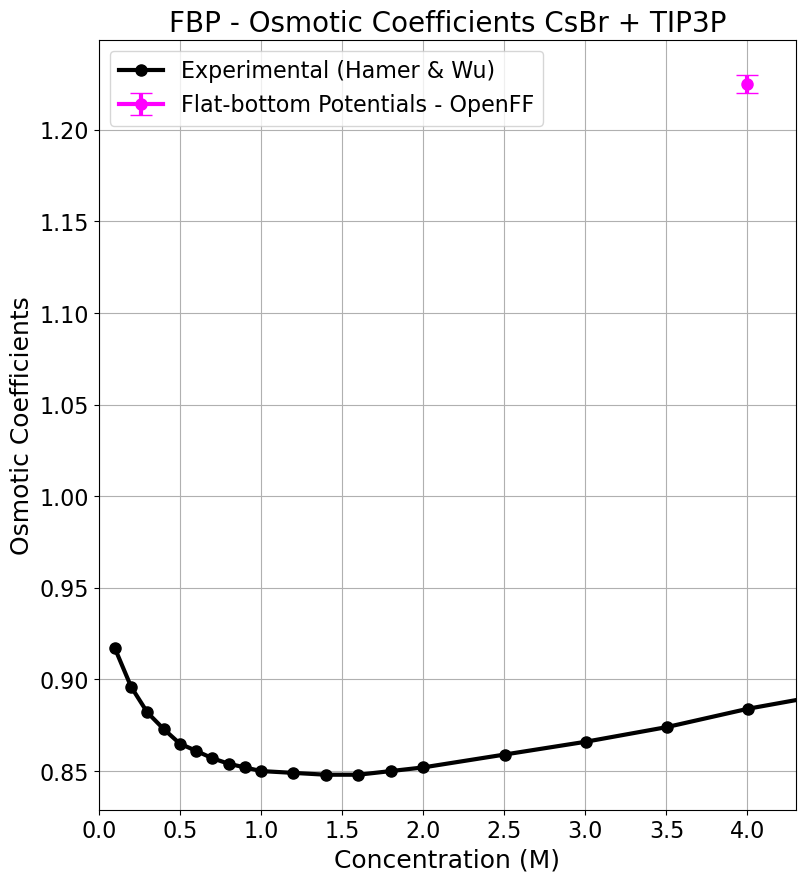

In [40]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(molalities, fbp_results['OC_Values'], yerr=fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenFF', linewidth=3, markersize=8)



plt.xlim(0,molalities[-1]+0.3)
plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
plt.title(f'FBP - Osmotic Coefficients {ion1}{ion2} + {water}', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.grid()
plt.savefig(f'{wdir}/ocs.png')
plt.show()

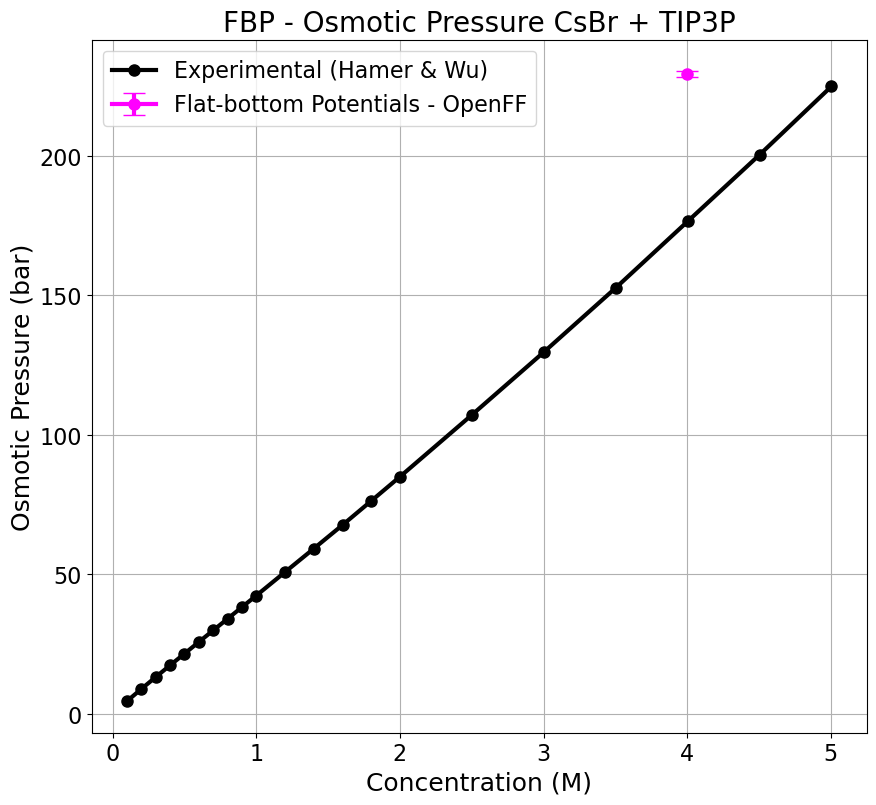

In [41]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))

# Experimental data
plt.plot(exp_concs, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(molalities, fbp_results['OP_Values'], yerr=fbp_results['OP_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenFF', linewidth=3, markersize=8)


plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)",fontsize=MEDIUM_SIZE)
plt.title(f'FBP - Osmotic Pressure {ion1}{ion2} + {water}', fontsize=BIGGER_SIZE)
plt.legend()
plt.grid()
plt.savefig(f'{wdir}/ops.png')
plt.show()